# DM1590 Final Project: ASL-Classifier
## Authors: Josephine Kuo, Vanja Vidmark, Kristi Francis, Robin Persson

---

# Background and motivation

We decided to train an AI-model to classify letters in the American hand sign alphabet from a live feed. 

Since none of us had any prior experience with live feeds in this context, we felt that we could learn something valuable that could be expanded upon in later courses. 

Accessibility refers to the extent to which an interactive product is accessible by as many people as possible.
We wanted to apply machine learning to increase accessibility for people who are hearing-impaired. Assistive technology like this makes the world a more democratic place, and what could be more important than that?

# Dataset

The database used consisted of approximately 87k 200x200 images consisting of handsigns for the letters A-Z along with the signs for space, delete, and nothing. We chose to ignore the last 3 as they weren't letters. It was created by the user "Akash" on Kaggle: https://www.kaggle.com/grassknoted/asl-alphabet.

# Methodology

Our idea was to create a program that can interpret what letter the user is doing in american sign langage and return the answer. This was done by detecting points in the hand using the pipeline MediaPipe Hands that will output 21 different landmarks of the hand given a static or live image. 

The unsupervised part was be to interpret what the pipeline collected and find patterns. We didn't know what data would be best to use in our algorithm and mostly considered using the coordinates themselves or angles between nodes of the wireframe. We setteled on using the coordinates which gave us a dataframe with 63 features. To reduce the dimensionality we used PCA. We also did K-means clusering to get a quick visualisation of possible clusters of our test data.

The supervised part consists of us taking the result from the unsupervised part and label it as different letters. For this we used KNN and QDA.

---

# Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
import string
import cv2
import time
import os
import tensorflow as tf
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Necessary functions and code

In [26]:
#Printing confusion matrices
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth

    # Begin CHANGES
    fst_empty_cell = (columnwidth - 3) // 2 * " " + "t\p" + (columnwidth - 3) // 2 * " "

    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES

    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")

    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

#For flattening an array
def flatten(t):
    return [item for sublist in t for item in sublist]

#Split the columns into 3 for each landmark (x, y, z)
def split_data(df_array):
    new_arr = []
    for i in range(len(df_array)):
        arr = [n.strip('() ') for n in df_array[i]]
        coords = [n.split(',') for n in arr]
        for j in range(len(coords)):
            coords[j] = [float(n) for n in coords[j]]
        coords = flatten(coords)
        new_arr.append(coords)
    return new_arr

#Extract the landmarks from live feed
def extractLandmarks(multi_hand_landmarks):
    result = []
    for i in range(len(multi_hand_landmarks[0].landmark)):
        x = multi_hand_landmarks[0].landmark[i].x
        y = multi_hand_landmarks[0].landmark[i].y
        z = multi_hand_landmarks[0].landmark[i].z
        result.extend([x, y, z])
    return np.array(result)


#Text formatting for the livefeed
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 3
fontColor              = (0,255,0)
thickness              = 1
lineType               = 2

# Pre-processing

Working with 87k images is somewhat impractical, and not very useful in itself. 
To circumvent this, we used a framework called Mediapipe made by Google. Given an image or a live feed, it outputs 21 different coordinates corresponding to different nodes (landmarks) on the hand. We fed our dataset to the model which generated the all the nodes for each image, a process which took approximately 7 hours. If no landmarks where found, it skipped that image. These were the parameters we later used for our model. When we generated the nodes we did it in the form (x, y, z) so the model only had 21 features. (Certain parts are commented out to prevent execution when running the notebook)

In [27]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def process_img(image):
    result = []
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.multi_hand_landmarks:
          return
        for i in range(len(results.multi_hand_landmarks[0].landmark)):
          x = results.multi_hand_landmarks[0].landmark[i].x
          y = results.multi_hand_landmarks[0].landmark[i].y
          z = results.multi_hand_landmarks[0].landmark[i].z
          result.append((x, y, z))
        return result

def processDataset(folder):
    result = []
    print('Processing...')
    letters = string.ascii_uppercase
    t0= time.process_time()
    row = []
    i = 0
    total = 82000
    for letter in letters:
        images = load_images_from_folder(folder + letter)
        for image in images:
            os.system('cls')
            print('Processing...{0}% ({1} images)'.format(round(100*i/total, 2), i))
            print("Time elapsed: {}s".format(round(time.process_time() - t0)))
            i += 1
            landmarks = process_img(image)
            if landmarks:
                result.append(landmarks)
                row.append(letter)
    print('Finished processing {} images'.format(i))
    df = pd.DataFrame(result)
    df.index = row
    df.to_csv('Dataset.csv')

'''
processDataset('Dataset/')
input('Press any key to exit')
'''

"\nprocessDataset('Dataset/')\ninput('Press any key to exit')\n"

#Create dataframe

The code below is dividing into train and test data using a 70/30-split and extracting all the x-, y- and z-coordinates to 63 separate features. Finally we create two new dataframes for train and test data with all 63 features. 

In [28]:
columnNames = np.arange(0, 63).astype(str).tolist()

df = pd.read_csv('Dataset.csv')

# Separates our class from our features
letters = df.iloc[:, 0]
df = df.iloc[:, 1:]
df = split_data(df.to_numpy())
X_train, X_test, y_train, y_test = train_test_split(df, letters, test_size=0.3)
LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)

# PCA

To reduce the dimensionality of the dataframe we applied PCA. The graph below shows the explained variance which is a measure of how well a model describes the actual data, for different numbers of components.

We chose to reduce our 63 features to 15 principal components because it was very close to 100%

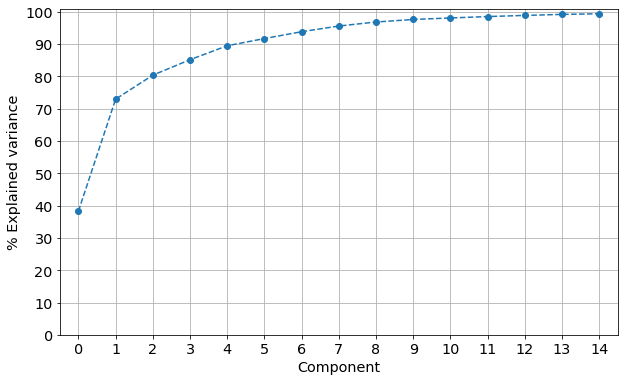

In [29]:
pca = PCA(n_components=15)

Xprime_train = pca.fit_transform(X_train)
Xprime_test = pca.transform(X_test)

columnNames = np.arange(0, 15).astype(str).tolist()


# Plots the explained variance ratio for different numbers of components
params = {'legend.fontsize': 'x-large','figure.figsize': (10, 6),
         'axes.labelsize': 'x-large','xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(100*np.cumsum(pca.explained_variance_ratio_),'o--')
plt.xlabel('Component'); plt.ylabel('% Explained variance')
plt.xticks(np.arange(0,pca.components_.shape[0],1))
plt.yticks(np.arange(0,101,10))
plt.xlim(0-0.5,pca.components_.shape[0]-0.5); plt.ylim(0,101)
ax.grid(); plt.show()

# K-means clustering
At this stage we were still unsure whether the coordinates in our dataframe were representative enough to be able to distinguish between letters at all. Therefore we wanted a quick visualisation of how our data could be clustered, and chose to try K-means clustering. In order to visualise our clusters we had to reduce the dimensions down to only 2, using PCA. We chose K as 26 which is the number of letters in the alphabet.

The graph is quite chaotic which isn’t surprising considering we reduced the dimensions from 63 to 2 and there are so many data points. We still thought that the clusters were good enough to move forward with the dataset we created.

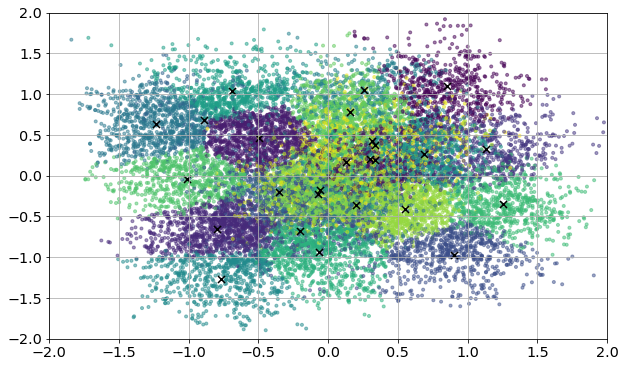

In [30]:
# PCA with two principal components
pca_K_means = PCA(n_components=2)

Xprime_train_K = pca.fit_transform(X_train)
Xprime_test_K = pca.transform(X_test)

columnNames_K = np.arange(0,2).astype(str).tolist()

df_train_K = pd.DataFrame(Xprime_train_K, columns= columnNames)
df_test_K =pd.DataFrame(Xprime_test_K, columns= columnNames)

# K-means clustering
K = 26
Xt = np.array(Xprime_test_K)

kmeans = KMeans(n_clusters=K)
kmeans.fit(Xt)


plt.scatter(Xt[:, 0], Xt[:, 1], alpha=0.5, c=kmeans.labels_, marker='.')
plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', marker='x')
plt.grid(); plt.show()

# KNN
**METHOD** The first classifier we tried was KNN. Firtly, we had to know how many neighbors we should use to get the biggest accuracy. To do so, we created a graph representing the error rate correlated to number of neighbors. By analyzing this graph, we saw that the best number of neigbors K to use is 3. We chose 3, because the more complex we make the model the greater the error rate gets. We did not want to overfit either by choosing only 1 or 2 neigbors.

Since KNN measures the distances between datapoints. We needed to define what distance we should use. We reasoned that manhattan distance was better for higher dimensionality, but since we reduced it to 12 when doing PCA we figured that euclydian distance would work out well.

We then fit the model, with 3 neigbors and predicted the data.

**WHY KNN?**

It is a fairly simple and easy classifier to implement.
KNN is a type of multiclass classification (It can classify with 3 or more classes), meaning that it does not make any assumptions about our data like statistical classifaications.
Altough, the limitation to KNN was that it was very time consuming. Since we have to calculate all the points in the data, the time it took to create a graph representing the error rate was fairly long.

**RESULTS OF KNN** We get a fairly high accuracy using KNN (98%). Altough, from the confusion matrix we can see that M/N and U/R a couple of times. This is also supported by the statisicfs given by the classification report. The F1 score (The weighted harmonic mean of precision and recall) show that U, M and N had a score of 92%, 93% and 94%, which is lower than other letters.

The reason behind this could be that N/M and U/R are fairly similar to eachother.

## Find the best K

Text(0, 0.5, 'Error Rate')

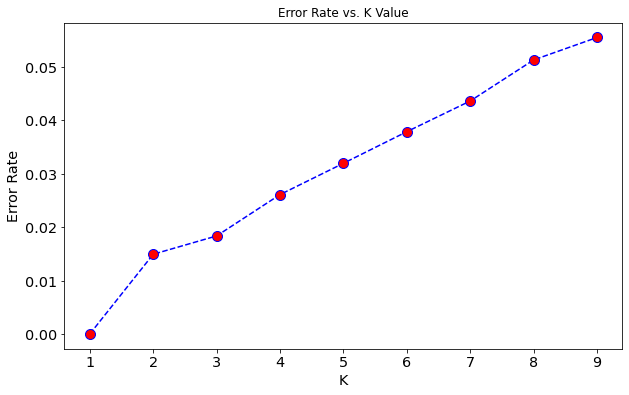

In [31]:
error_rate = []
# Will take some time
for i in range(1,10):
 
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(Xprime_test, y_test)
 pred_i = knn.predict(Xprime_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')


## Fit the data to the classifier and print the confusionmatrix

In [32]:
clf = KNeighborsClassifier(n_neighbors=3) #Choose number of neighbors to be 3. 

clf.fit(Xprime_train, y_train) # fit the classifier to the train data

pred_clf = clf.predict(Xprime_test) #Predict with the test data

# Confusion matrix and classification report below. 
confusion = confusion_matrix(y_test, pred_clf)
print(classification_report(y_test, clf.predict(Xprime_test)))

print_cm(confusion,
         ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
          'V', 'W', 'X', 'Y', 'Z'], hide_zeroes=True )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       655
           1       0.98      1.00      0.99       666
           2       0.99      1.00      0.99       601
           3       1.00      0.99      0.99       695
           4       0.99      0.99      0.99       682
           5       0.99      1.00      1.00       875
           6       0.99      0.99      0.99       700
           7       0.99      0.99      0.99       733
           8       0.99      0.98      0.99       715
           9       0.99      0.99      0.99       775
          10       0.97      0.97      0.97       880
          11       1.00      1.00      1.00       764
          12       0.95      0.95      0.95       456
          13       0.96      0.94      0.95       377
          14       0.99      0.99      0.99       677
          15       0.99      0.99      0.99       644
          16       1.00      0.99      1.00       637
          17       0.94    

# QDA
**METHOD**
This metod was fairly straight forward. Firstly we fit the model to the skLearn QDA model with out training data. Then predicted using out test data. Then we printed a confusion matrix and a classification report. 

**WHY QDA**
We assumed our classes to be gaussian distrubuted,and thus wanted to try QDA or LDA. We decided to go for QDA because every class has its own covariance matrix, meaning it is more "flexible" and therefor tends to fit data better than LDA. We knew that to many classes would be troublesome for QDA, but figured 26 could work. Although, the higher the dimension of the data set (the more predictors in a data set) the more parameters we have to estimate. This can lead to high variance and so we have to be careful when using QDA. But since we had a large amount of data and had used PCA to reduce dimensionality QDA was a better fit.

**RESULTS OF QDA**
Our result got close to the results of KNN. But we see that M gets mixed up in a strange way. But still, it is M/N and U/R that get mixed up.

**QDA VS KNN**
We belive that KNN would be a better fit, because it did not show the strange behaviour around M like QDA did. Also because KNN is a non-parametric approach, meaning that no assumptions have to be made regarding the data and the shape of the decision boundry. 

In [33]:
QDA_model = QuadraticDiscriminantAnalysis() #The model from sklearn
QDA_model.fit(Xprime_train, y_train) #Fit the model with the training data
QDA_pred = QDA_model.predict(Xprime_test) #Predict with test data

#Confusion matrix and classification report 
confusion_QDA = confusion_matrix(y_test, QDA_pred)
print(classification_report(y_test, clf.predict(Xprime_test)))

print_cm(confusion_QDA,
         ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
          'V', 'W', 'X', 'Y', 'Z'], hide_zeroes=True )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       655
           1       0.98      1.00      0.99       666
           2       0.99      1.00      0.99       601
           3       1.00      0.99      0.99       695
           4       0.99      0.99      0.99       682
           5       0.99      1.00      1.00       875
           6       0.99      0.99      0.99       700
           7       0.99      0.99      0.99       733
           8       0.99      0.98      0.99       715
           9       0.99      0.99      0.99       775
          10       0.97      0.97      0.97       880
          11       1.00      1.00      1.00       764
          12       0.95      0.95      0.95       456
          13       0.96      0.94      0.95       377
          14       0.99      0.99      0.99       677
          15       0.99      0.99      0.99       644
          16       1.00      0.99      1.00       637
          17       0.94    

## Neural networks: tuning the hyperparameters

Before we could start using neural networks, we had to tune the hyperparameters to fit our model. We opted for a multilayered perceptron consisting of an
input layer, hidden layer, and an output layer. Given the task and the size of our dataset, more hidden layers was not deemed necessary. The number of
neurons in the hidden layer was chosen to be 21 based on a thumb rule to use the mean of the number of neurons in the input- and output layer, respectively. The input layer have
15 neurons (number of features) and the output layer have 26 (number of classes), resulting in a mean of 21 (rounded up).

We also had to decide the number of epochs. This was done by analyzing the training- and validation loss, choosing a number where either started to show an upward trend.
As seen on the graph below, this turned out to be approx. 10 epochs.

# Neural networks

For the neural network approach, we chose to use Tensorflow. The accuracy was similar to KNN (around 97% on the test data), and the confusion matrix showed similar confusion around certain letter pairs as before. When used with the live feed though, the neural network seemed to perform better in recognizing hand signs.

In [34]:
classes = string.ascii_uppercase
model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(15, )),
    tf.keras.layers.Dense(21, activation='relu'),
    tf.keras.layers.Dense(26)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(Xprime_train, y_train, epochs=10, validation_data=(Xprime_test, y_test))
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
y_pred = [np.argmax(x) for x in probability_model.predict(Xprime_test)]

metrics = tf.keras.metrics.Accuracy()
metrics.update_state(y_test, y_pred)
print('Accuracy: ', metrics.result().numpy())
cm = tf.math.confusion_matrix(y_test, y_pred)
print_cm(cm, labels=string.ascii_uppercase, hide_zeroes=True)


Epoch 1/10
1321/1321 [==============================] - 7s 5ms/step - loss: 1.9315 - accuracy: 0.5960 - val_loss: 0.7836 - val_accuracy: 0.9127
Epoch 2/10
1321/1321 [==============================] - 6s 5ms/step - loss: 0.5027 - accuracy: 0.9367 - val_loss: 0.3599 - val_accuracy: 0.9483
Epoch 3/10
1321/1321 [==============================] - 8s 6ms/step - loss: 0.2873 - accuracy: 0.9573 - val_loss: 0.2518 - val_accuracy: 0.9600
Epoch 4/10
1321/1321 [==============================] - 7s 5ms/step - loss: 0.2143 - accuracy: 0.9643 - val_loss: 0.2026 - val_accuracy: 0.9651
Epoch 5/10
1321/1321 [==============================] - 8s 6ms/step - loss: 0.1781 - accuracy: 0.9690 - val_loss: 0.1755 - val_accuracy: 0.9675
Epoch 6/10
1321/1321 [==============================] - 7s 5ms/step - loss: 0.1563 - accuracy: 0.9722 - val_loss: 0.1579 - val_accuracy: 0.9705
Epoch 7/10
1321/1321 [==============================] - 8s 6ms/step - loss: 0.1415 - accuracy: 0.9736 - val_loss: 0.1456 - val_accuracy:

# Webcam input
To predict the labels in real-time using a webcam, the landmarks were simply extracted using Mediapipe, transformed, and finally fed into our model.

In [35]:
def predictData(landmarks):
    landmarks = pd.DataFrame(landmarks)
    landmarks = landmarks.transpose()
    landmarks_pca = pca.transform(landmarks)
    result = np.argmax(model.predict(landmarks_pca))
    return LE.inverse_transform([result])

# For webcam input, code partially taken from: https://google.github.io/mediapipe/solutions/hands
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
        model_complexity=0,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        landmarks = results.multi_hand_landmarks
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
            prediction = predictData(extractLandmarks(landmarks))
            if prediction:
                image = cv2.flip(image, 1)
                cv2.putText(image, prediction[0], (100, 200), font, fontScale, fontColor, thickness, lineType)
                image = cv2.flip(image, 1)
        # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
        if cv2.waitKey(5) & 0xFF == 27:
            break
cap.release()

---
# Discussion

Given our dataset, our model performs very well with an accuracy of about 98%
for the test data. This is mainly due to the high similarities between the images in the dataset. Since the images depict only a single hand in a constant lighting scenario, our model is heavily biased on the proportions of this hand. Different skin tones, hand sizes, lighting scenarios and angles in the training data would probably yield better results in a real-world scenario if we could extend our dataset with these parameters. 


Similar signs like M/N and U/R are heavily confused by our model. Extending the training data with more images depicting these signs might lower the confusion-rate. 

When reducing data, there is a big risk of us missing important information. Therefor we should have used K-Fold Cross Validation and use k number of subsets of our data to train on. And then use a one of the subsets to train with. This would reduce biases that could occur while reducing data.


Moving signs like Z and J can not be expressed with our model. Solving this issue would require our code to take movement into consideration by extracting key points from the live feed and comparing how the coordinates change between frames. This is perfectly doable but not within our scope for this project.

# Acknowledgments
For each group member, describe what they did.

We cooparated alot on the different parts. We all worked together on brainstorming ideas, structuring up the work (using a flowchart), figuring out how to structure our data, the presentation, etc.

But our main responsabilities where...

Josephine - Classification with KNN and QDA. Including the the analyzation of confusion matrixes and optimization (number of neighbors in KNN).
Vanja - Unsupervised learning, PCA and KMeans.

Kristi - Data preprocessing, neural networks, webcam input, PCA. 

Robin - Research regarding supervised and unsupervised methods aswell as neural networks. KNN and PCA implementation and optimization.

# Final meme


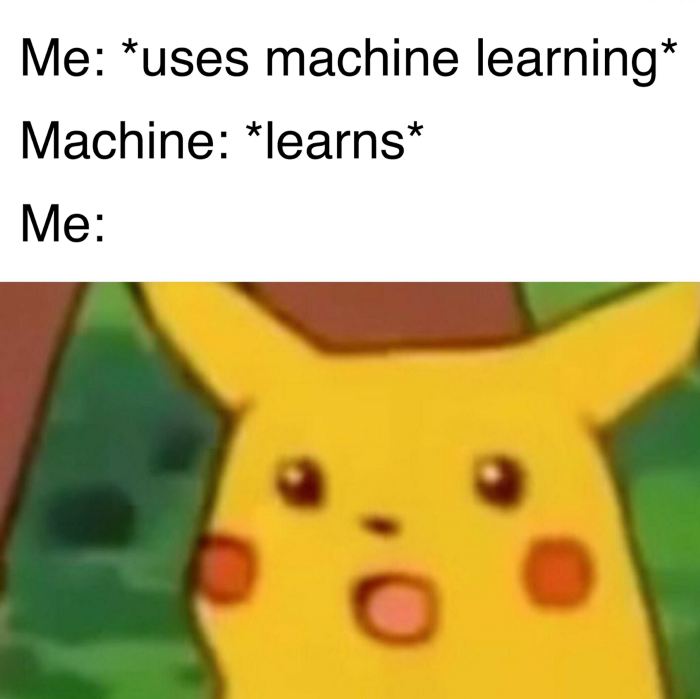